# Libraries

In [20]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

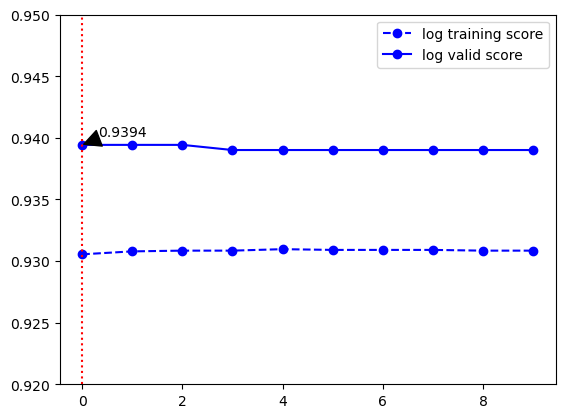

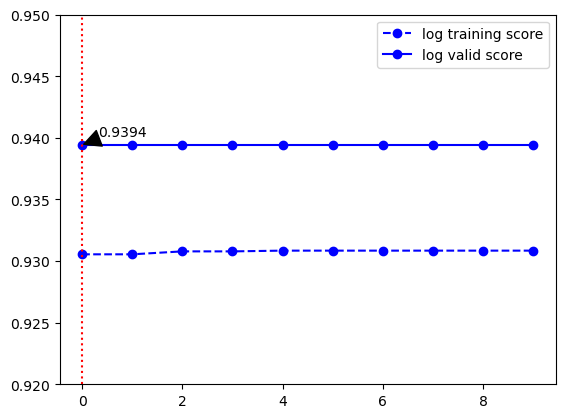

************************************************************
There are 6 set of X
X_train_selected_t1, X_train_selected_t2, X_valid_selected_t1,X_valid_selected_t2,X_test_selected_t1,X_test_selected_t2
------------------------------------------------------------
Normalized version
X_train_selected_t1_norm, X_train_selected_t2_norm, X_valid_selected_t1_norm,X_valid_selected_t2_norm,X_test_selected_t1_norm,X_test_selected_t2_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [21]:
%run Data_preprocessing_realmean_final.ipynb

In [22]:
print(X_train_selected_t1_norm.shape)
print(X_valid_selected_t1_norm.shape)
print(X_test_selected_t1_norm.shape)


X_train_norm = X_train_selected_t1_norm
X_valid_norm = X_valid_selected_t1_norm
X_test_norm = X_test_selected_t1_norm

(16760, 52)
(2394, 52)
(4790, 52)


# Imbalanced Learning

In [23]:
Full = pd.DataFrame(np.concatenate((X_train_norm,pd.DataFrame(y_train_t1_value)),axis=1))
Full

label0 = Full[Full[51]==0]
label1 = Full[Full[51]==1]
print(label0.shape,label1.shape)

(0, 53) (0, 53)


In [24]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(X_train_norm,pd.DataFrame(y_train_t1_value))


y_over = pd.DataFrame(y_over)
y_over.shape
x_over.shape

(31070, 52)

In [25]:
Full = pd.DataFrame(np.concatenate((x_over,y_over),axis=1))
Full

label0 = Full[Full[51]==0]
label1 = Full[Full[51]==1]
print(label0.shape,label1.shape)

(0, 53) (0, 53)


In [26]:
X_train_norm=x_over

y_train_t1 = y_over

# Neural Network Using Sklearn build in function

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

clf = MLPClassifier(solver="lbfgs",
                    alpha=1e-5,
                    hidden_layer_sizes=(5,2),
                    random_state=1,
                    max_iter=200)

clf.fit(X_train_norm,y_train_t1)

clf.score(X_valid_norm, y_valid_t1_value)

0.7347535505430243

In [28]:
y_pred = pd.DataFrame(clf.predict_proba(X_valid_norm))
y_pred.iloc[:,1:2]

,1
0,0.791650
1,0.954251
2,0.069240
3,0.001396
4,0.012596
...,...
2389,0.075323
2390,0.196014
2391,0.829371
2392,0.606835


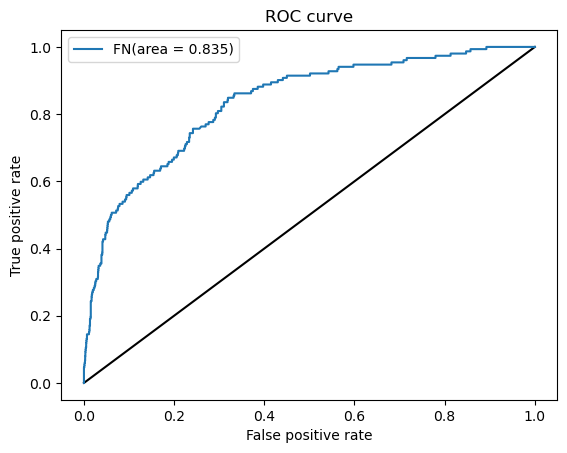

In [29]:
y_pred = pd.DataFrame(clf.predict_proba(X_valid_selected_t1_norm))
y_pred = np.array(y_pred.iloc[:,1:2])
fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)



plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='FN(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve")
plt.legend(loc="best")
plt.show()

# Hyperparameter and setting tuning

## layers

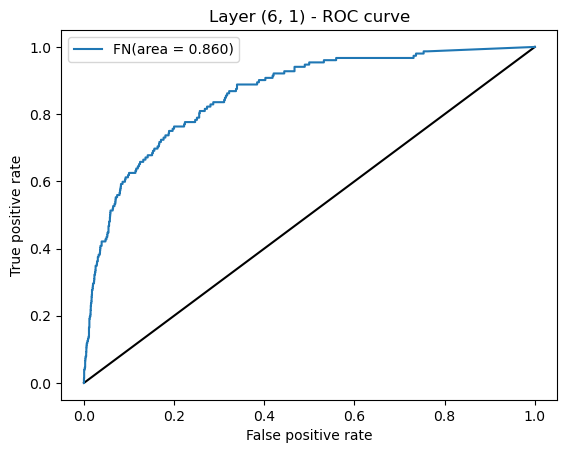

In [30]:
layer_list = []
fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
for i in range(1,40,5):
    for j in range(1,40,5):
        layer_list.append((i,j))
        
for i in layer_list:
    clf = MLPClassifier(solver="lbfgs",
                        alpha=1e-5,
                        hidden_layer_sizes=i,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = pd.DataFrame(clf.predict_proba(X_valid_selected_t1_norm))
    y_pred = np.array(y_pred.iloc[:,1:2])
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"Layer {layer_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()

In [31]:
best_layernumber = layer_list[index]
best_layernumber

(6, 1)

## Solver

<Figure size 500x500 with 0 Axes>

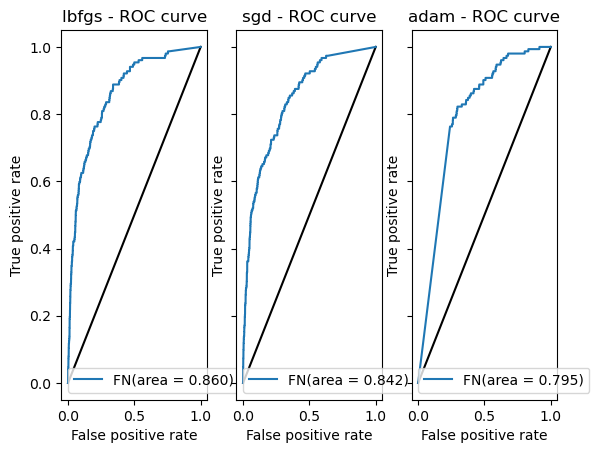

In [32]:
solver_list = ["lbfgs","sgd","adam"]
fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]

for i in solver_list:
    clf = MLPClassifier(solver=i,
                        alpha=1e-5,
                        hidden_layer_sizes=best_layernumber,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = pd.DataFrame(clf.predict_proba(X_valid_selected_t1_norm))
    y_pred = np.array(y_pred.iloc[:,1:2])
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
plt.figure(figsize=(5,5))
for j in range(3):
    plt.figure(1)
    axes[j].plot([0, 1], [0, 1], 'k-')
    axes[j].plot(fpr_lst[j], tpr_lst[j], label='FN(area = {:.3f})'.format(roc_auc_lst[j]))
    axes[j].set_xlabel('False positive rate')
    axes[j].set_ylabel('True positive rate')
    axes[j].set_title(f"{solver_list[j]} - ROC curve")
    axes[j].legend(loc="best")
plt.show()

In [33]:
index = roc_auc_lst.index(max(roc_auc_lst))
best_solver = solver_list[index]
best_solver

'lbfgs'

## Learning rate tuning

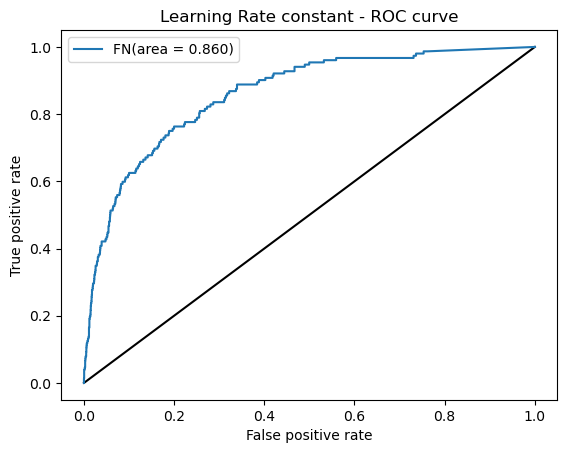

In [34]:
fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
lr_list = ["constant", "invscaling", "adaptive"]

for i in lr_list:
    clf = MLPClassifier(solver=best_solver,
                        alpha=1e-5,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate=i,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = pd.DataFrame(clf.predict_proba(X_valid_selected_t1_norm))
    y_pred = np.array(y_pred.iloc[:,1:2])
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"Learning Rate {lr_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()

In [35]:
index = roc_auc_lst.index(max(roc_auc_lst))
best_lr_choice =  lr_list[index]
best_lr_choice

'constant'

## Regularization rate

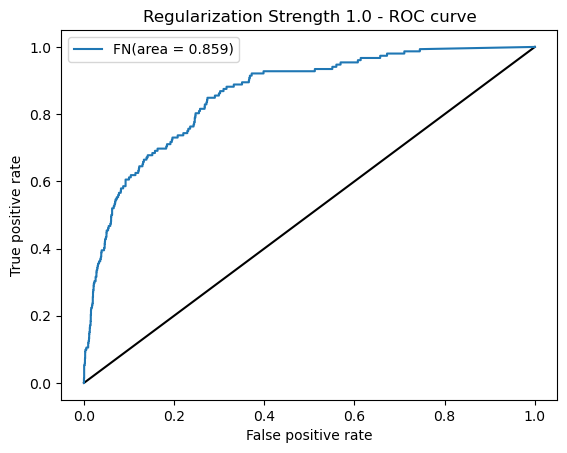

In [36]:

fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
reg_list = np.linspace(0,1,11)

for i in reg_list:
    clf = MLPClassifier(solver=best_solver,
                        alpha=i,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate=best_lr_choice,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = pd.DataFrame(clf.predict_proba(X_valid_selected_t1_norm))
    y_pred = np.array(y_pred.iloc[:,1:2])
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"Regularization Strength {reg_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()

In [37]:
index = roc_auc_lst.index(max(roc_auc_lst))
best_reg_choice =  reg_list[index]
best_reg_choice

1.0

## Random State

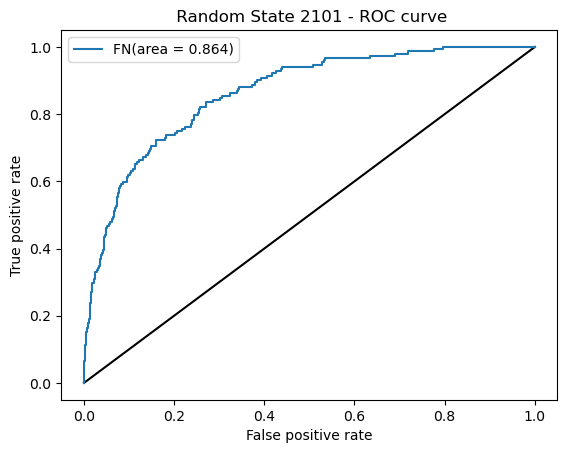

In [38]:

fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
rs_list = list(range(1,3612,100))

for i in rs_list:
    clf = MLPClassifier(solver=best_solver,
                        alpha=best_reg_choice,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate=best_lr_choice,
                        random_state=i,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = pd.DataFrame(clf.predict_proba(X_valid_selected_t1_norm))
    y_pred = np.array(y_pred.iloc[:,1:2])
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f" Random State {rs_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()



In [39]:
index = roc_auc_lst.index(max(roc_auc_lst))
best_rs_choice =  rs_list[index]
best_rs_choice

2101

# Final Model

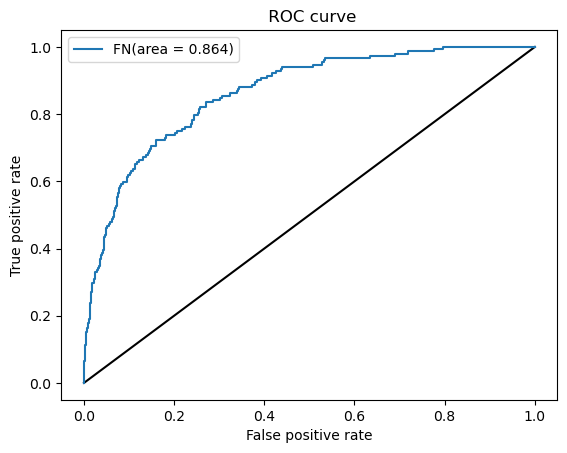

In [57]:
clf1 = MLPClassifier(solver=best_solver,
                        alpha=best_reg_choice,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate=best_lr_choice,
                        random_state=best_rs_choice,
                        max_iter=200)

clf1.fit(X_train_norm, y_train_t1)
clf1.score(X_valid_norm, y_valid_t1_value)
y_pred = pd.DataFrame(clf1.predict_proba(X_valid_selected_t1_norm))
y_pred = np.array(y_pred.iloc[:,1:2])
fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='FN(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f" ROC curve")
plt.legend(loc="best")
plt.show()

# Test

In [58]:
X_test_norm

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
Id,,,,,,,,,,,,,,,,,,,,,
0,-3.758935e-17,6.987436e-18,7.204217e-18,0.020717,-2.126698e-17,6.707220e-18,1.044049,1.351566e-18,-0.697027,-3.998435e-01,...,0.421136,-1.552845,0.716565,-0.524059,1.064077,1.860180e+00,3.892282e+00,0.000000,-6.814678e-18,0.646113
1,-3.350325e-01,1.689009e+00,-1.149066e-01,-0.805232,-3.169688e-01,-4.008503e-01,0.879460,-3.755694e-01,-0.287137,-2.818030e-01,...,-0.240195,0.000000,0.051625,-0.374367,0.166202,2.764783e-17,1.019919e-17,0.000000,-1.246132e-01,2.256627
2,-3.027909e-01,9.718193e-01,3.519937e-01,-0.289014,-3.313623e-01,-8.297798e-01,0.550284,-5.542870e-01,-0.471169,6.034999e-01,...,-0.520031,0.000000,-0.026603,0.175292,-1.267372,2.764783e-17,1.019919e-17,0.000000,-6.249432e-01,-0.576068
3,-3.758935e-17,6.987436e-18,7.204217e-18,-0.908476,-2.126698e-17,6.707220e-18,-0.313803,1.351566e-18,-0.069644,1.303882e-17,...,0.590545,-2.030655,-0.730658,-0.030969,1.559512,1.320341e+00,1.253576e+00,0.000000,2.714814e-01,-0.640393
4,-3.640500e-01,6.987436e-18,-1.780012e-01,-0.908476,-3.375310e-01,2.601656e+00,-0.190362,-5.542870e-01,-0.370788,-1.344167e+00,...,0.618523,0.000000,0.364538,-1.661466,1.981568,2.764783e-17,1.019919e-17,0.000000,-6.814678e-18,-1.512358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,-3.758935e-17,6.987436e-18,7.204217e-18,-0.598745,-2.126698e-17,6.707220e-18,1.784695,1.351566e-18,0.030737,9.576212e-01,...,0.214572,-2.448740,0.442766,-0.414883,-1.052785,-1.098668e+00,-4.023835e+00,0.000000,-1.071546e+00,-0.468859
4786,-3.758935e-17,6.987436e-18,7.204217e-18,1.693265,-2.126698e-17,6.707220e-18,-0.807567,1.351566e-18,2.309391,8.395808e-01,...,-0.009641,0.000000,-1.878006,1.982437,-0.073665,2.764783e-17,1.019919e-17,-0.568388,-4.465473e-01,-0.011435
4787,-3.758935e-17,6.987436e-18,7.204217e-18,-0.753610,-2.126698e-17,6.707220e-18,-0.807567,1.351566e-18,-0.697027,1.303882e-17,...,-0.021665,0.238945,-0.484798,-0.193140,0.563954,-2.170276e-01,-6.577652e-02,0.000000,1.366649e-01,-0.466000


In [59]:
result = pd.DataFrame(clf1.predict_proba(X_test_norm))
result = result.iloc[:,1:2]
result

,1
0,0.300262
1,0.063385
2,0.062017
3,0.011125
4,0.014191
...,...
4785,0.045602
4786,0.071928
4787,0.090552
4788,0.211497


In [62]:

result = pd.DataFrame(clf1.predict_proba(X_test_norm))
result = np.array(result.iloc[:,1:2])
result
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test_realmean.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1.sum(axis=0)

Predicted    1329.361824
dtype: float64